#### Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 1, 8, 14, 58, 34, 763938)

#### Connect to Hopsworks Feature Store

In [3]:
with open('../data/hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login()
fs = project.get_feature_store() 


2025-01-08 14:58:34,769 INFO: Initializing external client
2025-01-08 14:58:34,769 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-08 14:58:36,422 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1207502


#### Feature View Retrieval


In [4]:
feature_view = fs.get_feature_view(
    name='accidents_fv',
    version=1,
)

#### Download the model from Model Registry

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="accident_model",
    version=4,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.3360655E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'int'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### Get Weather Forecast Features with Feature View


In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.74s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,day_of_week
0,2025-01-15 00:00:00+00:00,1.55,0.0,4.334974,265.236450,Stockholm,2
1,2025-01-09 00:00:00+00:00,-2.40,0.0,6.952754,248.749420,Stockholm,3
2,2025-01-13 00:00:00+00:00,2.70,0.3,23.507753,242.650208,Stockholm,0
3,2025-01-10 00:00:00+00:00,-0.10,0.1,18.861387,13.240531,Stockholm,4
4,2025-01-16 00:00:00+00:00,3.20,0.0,8.759178,260.537750,Stockholm,3
5,2025-01-12 00:00:00+00:00,-3.75,0.0,14.081477,327.528839,Stockholm,6
6,2025-01-14 00:00:00+00:00,3.00,0.1,16.267857,294.863678,Stockholm,1
7,2025-01-11 00:00:00+00:00,-2.40,0.0,27.002399,359.236115,Stockholm,5
8,2025-01-17 00:00:00+00:00,2.85,0.0,12.864649,287.928009,Stockholm,4


#### Making the predictions

In [8]:
batch_data['predicted_accidents'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'day_of_week']])
batch_data.sort_values(by='date', inplace=True)

batch_data


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,day_of_week,predicted_accidents
1,2025-01-09 00:00:00+00:00,-2.40,0.0,6.952754,248.749420,Stockholm,3,2.223333
3,2025-01-10 00:00:00+00:00,-0.10,0.1,18.861387,13.240531,Stockholm,4,3.723760
7,2025-01-11 00:00:00+00:00,-2.40,0.0,27.002399,359.236115,Stockholm,5,4.660880
5,2025-01-12 00:00:00+00:00,-3.75,0.0,14.081477,327.528839,Stockholm,6,2.950451
2,2025-01-13 00:00:00+00:00,2.70,0.3,23.507753,242.650208,Stockholm,0,2.723643
6,2025-01-14 00:00:00+00:00,3.00,0.1,16.267857,294.863678,Stockholm,1,3.226831
0,2025-01-15 00:00:00+00:00,1.55,0.0,4.334974,265.236450,Stockholm,2,2.073458
4,2025-01-16 00:00:00+00:00,3.20,0.0,8.759178,260.537750,Stockholm,3,2.328290
8,2025-01-17 00:00:00+00:00,2.85,0.0,12.864649,287.928009,Stockholm,4,2.386230


In [9]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 1 to 8
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         9 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          9 non-null      float32                
 2   precipitation_sum            9 non-null      float32                
 3   wind_speed_10m_max           9 non-null      float32                
 4   wind_direction_10m_dominant  9 non-null      float32                
 5   city                         9 non-null      object                 
 6   day_of_week                  9 non-null      int32                  
 7   predicted_accidents          9 non-null      float32                
dtypes: datetime64[us, Etc/UTC](1), float32(5), int32(1), object(1)
memory usage: 432.0+ bytes


#### Saving the predictions (for monitoring) to a Feature Group

In [10]:
batch_data['city'] = "Stockholm"
batch_data['country'] = "Sweden"
batch_data['predicted_accidents'] = batch_data['predicted_accidents'].round(0).astype(int)
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,day_of_week,predicted_accidents,country,days_before_forecast_day
1,2025-01-09 00:00:00+00:00,-2.40,0.0,6.952754,248.749420,Stockholm,3,2,Sweden,1
3,2025-01-10 00:00:00+00:00,-0.10,0.1,18.861387,13.240531,Stockholm,4,4,Sweden,2
7,2025-01-11 00:00:00+00:00,-2.40,0.0,27.002399,359.236115,Stockholm,5,5,Sweden,3
5,2025-01-12 00:00:00+00:00,-3.75,0.0,14.081477,327.528839,Stockholm,6,3,Sweden,4
2,2025-01-13 00:00:00+00:00,2.70,0.3,23.507753,242.650208,Stockholm,0,3,Sweden,5
6,2025-01-14 00:00:00+00:00,3.00,0.1,16.267857,294.863678,Stockholm,1,3,Sweden,6
0,2025-01-15 00:00:00+00:00,1.55,0.0,4.334974,265.236450,Stockholm,2,2,Sweden,7
4,2025-01-16 00:00:00+00:00,3.20,0.0,8.759178,260.537750,Stockholm,3,2,Sweden,8
8,2025-01-17 00:00:00+00:00,2.85,0.0,12.864649,287.928009,Stockholm,4,2,Sweden,9


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 1 to 8
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         9 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          9 non-null      float32                
 2   precipitation_sum            9 non-null      float32                
 3   wind_speed_10m_max           9 non-null      float32                
 4   wind_direction_10m_dominant  9 non-null      float32                
 5   city                         9 non-null      object                 
 6   day_of_week                  9 non-null      int32                  
 7   predicted_accidents          9 non-null      int64                  
 8   country                      9 non-null      object                 
 9   days_before_forecast_day     9 non-null      int64                  
dtypes: datetime

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-01-08 14:58:46,850 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



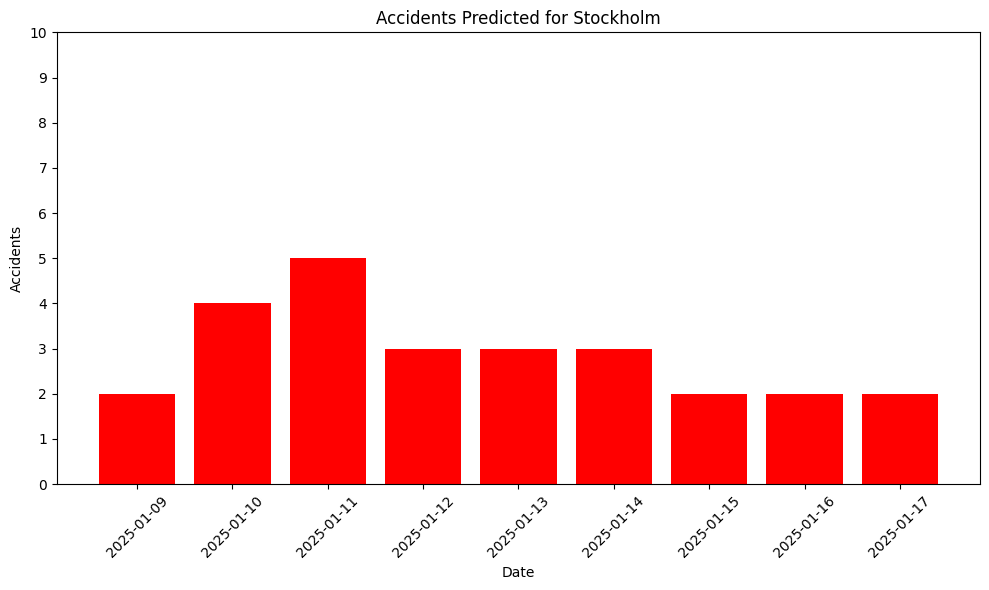

In [12]:
import os
from functions import util
file_path = "../data/forecast.png"
os.makedirs(os.path.dirname(file_path), exist_ok=True)
plt = util.plot_accidents_forecast("Svealand", batch_data, file_path=file_path)
plt.show()

In [13]:
import os
from functions import util
file_path = "../data/forecast_table.png"
os.makedirs(os.path.dirname(file_path), exist_ok=True)
plt = util.plot_accidents_table("Svealand", batch_data, file_path=file_path)
plt.show()

In [14]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='accidents_predictions',
    description='Accidents prediction monitoring',
    version=1,
    primary_key=['city','date','days_before_forecast_day'],
    event_time="date"
)

In [15]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

FeatureStoreException: Features are not compatible with Feature Group schema: 
 - predicted_accidents (expected type: 'float', derived from input: 'bigint') has the wrong type.
Note that feature (or column) names are case insensitive and spaces are automatically replaced with underscores.